In [1]:
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import torch
import json, os, shutil
from ultralytics import YOLO

# приведение анотаций в формат YOLO

In [338]:
for file in ['test', 'val', 'train']:
    with open(f'/home/misha/Загрузки/annotations_{file}.json') as f:
        imgs_anns = json.load(f)
    for seg in imgs_anns['annotations']:
        if seg['category_id'] == 0 or seg['category_id'] == 1:
            maxX = np.max(seg['segmentation'][0][::2])
            minX = np.min(seg['segmentation'][0][::2])
            maxY = np.max(seg['segmentation'][0][1::2])
            minY = np.min(seg['segmentation'][0][1::2])
            height = imgs_anns['images'][seg['image_id']]['height']
            width = imgs_anns['images'][seg['image_id']]['width']
            img_name = imgs_anns['images'][seg['image_id']]['file_name']
            center_norm = ((maxX + minX) / 2 / width, (maxY + minY) / 2 / height)
            bbox_width_norm = (maxX - minX) / width
            bbox_height_norm = (maxY - minY) / height
            if seg['image_id'] % 10 != 0:
                if os.path.exists(f'/home/misha/YOLOdataset/train/labels/{img_name[:-4]}.txt') == False:
                    f = open(f'/home/misha/YOLOdataset/train/labels/{img_name[:-4]}.txt', 'w+')
                    shutil.copy(f'/home/misha/Загрузки/images/images/{img_name}', f'/home/misha/YOLOdataset/train/images/')
                else:
                    f = open(f'/home/misha/YOLOdataset/train/labels/{img_name[:-4]}.txt', 'a+')
            else:
                if os.path.exists(f'/home/misha/YOLOdataset/val/labels/{img_name[:-4]}.txt') == False:
                    f = open(f'/home/misha/YOLOdataset/val/labels/{img_name[:-4]}.txt', 'w+')
                    shutil.copy(f'/home/misha/Загрузки/images/images/{img_name}', f'/home/misha/YOLOdataset/val/images/')
                else:
                    f = open(f'/home/misha/YOLOdataset/val/labels/{img_name[:-4]}.txt', 'a+')
            f.write(f'{seg["category_id"]} {center_norm[0]} {center_norm[1]} {bbox_width_norm} {bbox_height_norm}\n')

# выбор аугментаций из библиотеки albumentations

In [10]:
transform = A.Compose([
    A.Blur(blur_limit=10, p=0.7),
    A.Downscale(p=0.3),
    A.RGBShift(p=0.3, r_shift_limit=0, g_shift_limit=10, b_shift_limit=20),
    # A.OneOf([
    #     A.Spatter(p=0.5, cutout_threshold = 0.7, mean=0.5, std=0.275),
    #     A.PixelDropout(dropout_prob=0.15, p=0.5)
    # ], p=0.4),
    A.PixelDropout(dropout_prob=0.15, p=0.25),
    A.ToGray(p=1),
    A.RandomBrightness(p=1, limit=0.1),
    A.Rotate(limit = 10, p=0.85),
    A.RandomCropFromBorders(p=0.2)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


In [11]:
file = open('/home/misha/YOLOdataset/train/labels/0_1.txt').read()
bboxes_str = file.split('\n')
bboxes = [x.split(' ')[1:] for x in bboxes_str]
bboxes = np.float32(bboxes[:-1])
class_labels = [x.split(' ')[0] for x in bboxes_str[:-1]]

In [12]:
def visualize_bbox(img, bbox):
    x_min = round((np.float32(bbox[0]) - np.float32(bbox[2])/2) * img.shape[1])
    x_max = round((np.float32(bbox[0]) + np.float32(bbox[2])/2) * img.shape[1])
    y_min = round((np.float32(bbox[1]) - np.float32(bbox[3])/2) * img.shape[0])
    y_max = round((np.float32(bbox[1]) + np.float32(bbox[3])/2) * img.shape[0])
    # print(bbox)
    # print(x_min,y_min,x_max,y_max, np.float32(bbox[0]), np.float32(bbox[2])/2, np.float32(bbox[0]) - np.float32(bbox[2])/2)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(255,0,0), thickness=2)
    return img

In [13]:
img = cv2.imread('/home/misha/YOLOdataset/train/images/0_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for bbox in bboxes:
    img = visualize_bbox(img, bbox)
plt.figure(figsize=(12, 12))
plt.imshow(img)

In [328]:
transformed = transform(image=cv2.imread('/home/misha/YOLOdataset/train/images/0_1.jpg'), bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
#print(len(bboxes), len(transformed_bboxes))

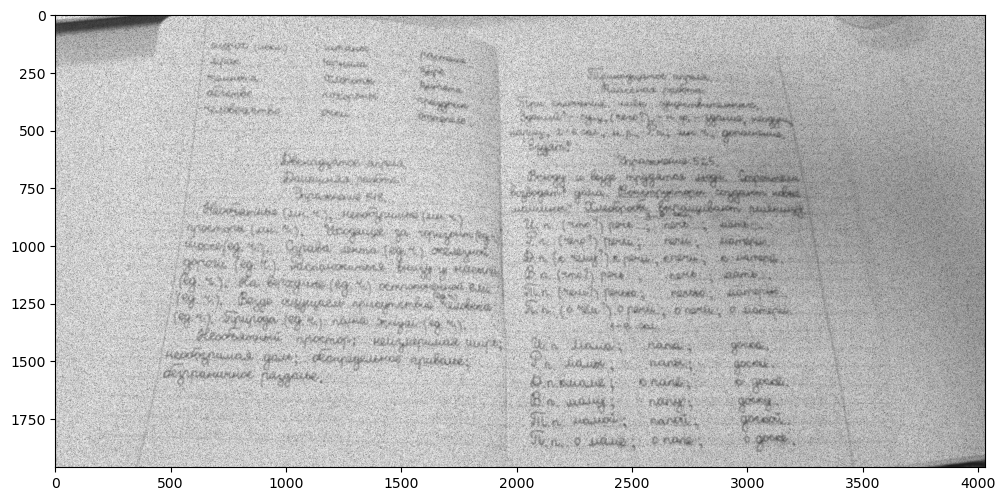

In [330]:
# for bbox in transformed_bboxes:
#     ne_img = visualize_bbox(transformed_image, bbox)
plt.figure(figsize=(12, 12))
plt.imshow(transformed_image)

### хорошие аугмаентации:
- Blur(blur_limit=10, p=0.7)
- Downscale(p=0.3)
- RGBShift(p=1, r_shift_limit=0, g_shift_limit=10, b_shift_limit=20)
- Spatter(p=0.2)
- ToGray(p=0.5)
- RandomBrightness(p=1, limit=0.2)
- Rotate(limit = 10, p=0.85)
- RandomCropFromBorders(p=0.2)
- PixelDropout(dropout_prob=0.15,p=0.2) / вместо spatter
### нужно сделать одни аугментации постоянные, чтобы они были похожи на сканы, а другие рандомные

# Аугментируем данные

In [95]:
transform_pipeline = A.Compose([
    A.Blur(blur_limit=10, p=0.7),
    A.Downscale(p=0.3),
    A.RGBShift(p=0.3, r_shift_limit=0, g_shift_limit=10, b_shift_limit=20),
    A.PixelDropout(dropout_prob=0.15, p=0.25),
    A.ToGray(p=0.9),
    A.RandomBrightness(p=1, limit=0.1),
    A.Rotate(limit = 10, p=0.85),
    A.RandomCropFromBorders(p=0.2)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


In [340]:
dir_path = '/home/misha/YOLOdataset/train/'
list_dir = sorted(os.listdir(f'{dir_path}images/'))
for id, path in enumerate(list_dir):
    file = open(f'{dir_path}labels/{path[:-4]}.txt').read()
    bboxes_str = file.split('\n')
    bboxes = [x.split(' ')[1:] for x in bboxes_str]
    bboxes = np.float32(bboxes[:-1])
    class_labels = [x.split(' ')[0] for x in bboxes_str[:-1]]
    img = cv2.imread(f'{dir_path}images/{path}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(1, 6):
        transformed = transform_pipeline(image=img, bboxes=bboxes, class_labels=class_labels)
        cv2.imwrite(f'{dir_path}images/{path[:-4]}({i}).jpg', transformed['image'])
        f = open(f'{dir_path}labels/{path[:-4]}({i}).txt', 'w+')
        for bbox, label in zip(transformed['bboxes'], transformed['class_labels']):
            f.write(f'{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n')

ValueError: In YOLO format all coordinates must be float and in range (0, 1]

In [ ]:
dir_path = '/home/misha/YOLOdataset/train/'
#list_dir = sorted(os.listdir(f'{dir_path}images/'))
for id, path in enumerate(list_dir):
    if os.path.exists(f'{dir_path}images/{path[:-4]}(1).jpg') == False:
        print(path)
        file = open(f'{dir_path}labels/{path[:-4]}.txt').read()
        bboxes_str = file.split('\n')
        bboxes = [x.split(' ')[1:] for x in bboxes_str]
        bboxes = np.float32(bboxes[:-1])
        class_labels = [x.split(' ')[0] for x in bboxes_str[:-1]]
        img = cv2.imread(f'{dir_path}images/{path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for i in range(1, 6):
            transformed = transform_pipeline(image=img, bboxes=bboxes, class_labels=class_labels)
            cv2.imwrite(f'{dir_path}images/{path[:-4]}({i}).jpg', transformed['image'])
            f = open(f'{dir_path}labels/{path[:-4]}({i}).txt', 'w+')
            for bbox, label in zip(transformed['bboxes'], transformed['class_labels']):
                f.write(f'{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n')

### небольшие аугментации валидационной выборки

In [347]:
transform_pipeline_valid = A.Compose([
    A.ToGray(p=0.9),
    A.RandomBrightness(p=1, limit=0.075),
    A.Rotate(limit = 10, p=0.85),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [348]:
dir_path = '/home/misha/YOLOdataset/val/'
list_dir = sorted(os.listdir(f'{dir_path}images/'))
for id, path in enumerate(list_dir):
    file = open(f'{dir_path}labels/{path[:-4]}.txt').read()
    bboxes_str = file.split('\n')
    bboxes = [x.split(' ')[1:] for x in bboxes_str]
    bboxes = np.float32(bboxes[:-1])
    class_labels = [x.split(' ')[0] for x in bboxes_str[:-1]]
    img = cv2.imread(f'{dir_path}images/{path}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(1, 4):
        transformed = transform_pipeline_valid(image=img, bboxes=bboxes, class_labels=class_labels)
        cv2.imwrite(f'{dir_path}images/{path[:-4]}({i}).jpg', transformed['image'])
        f = open(f'{dir_path}labels/{path[:-4]}({i}).txt', 'w+')
        for bbox, label in zip(transformed['bboxes'], transformed['class_labels']):
            f.write(f'{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n')

# Обучение модели

In [2]:
model = YOLO('yolov8m')
results = model.train(data='YOLO.yaml', epochs=10, imgsz=480)

New https://pypi.org/project/ultralytics/8.0.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.227 🚀 Python-3.11.5 torch-2.1.2 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5938MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=YOLO.yaml, epochs=10, patience=50, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=F

train: Scanning /home/misha/YOLOdataset/train/labels.cache... 10395 images, 621 backgrounds, 0 corrupt: 100%|█

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /home/misha/YOLOdataset/val/labels.cache... 786 images, 68 backgrounds, 0 corrupt: 100%|████████

val: WARNING ⚠️ /home/misha/YOLOdataset/val/images/104_1029(1).jpg: 2 duplicate labels removed
val: WARNING ⚠️ /home/misha/YOLOdataset/val/images/104_1029(2).jpg: 2 duplicate labels removed
val: WARNING ⚠️ /home/misha/YOLOdataset/val/images/104_1029(3).jpg: 2 duplicate labels removed
val: WARNING ⚠️ /home/misha/YOLOdataset/val/images/104_1029.JPG: 2 duplicate labels removed


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 8 dataloader workers
Logging results to runs/detect/train6
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      5.84G       1.82     0.9509      1.116       1165        480: 100%|██████████| 661/661 [03:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/

                   all        804     126338      0.676      0.406      0.459      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      5.71G      1.623     0.7572      1.029       1092        480: 100%|██████████| 661/661 [03:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/

                   all        804     126338      0.637      0.474      0.489      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      5.41G      1.566     0.7214      1.011        584        480: 100%|██████████| 661/661 [03:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/


                   all        804     126338      0.613      0.489      0.498       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       5.9G      1.516     0.6917     0.9983        862        480: 100%|██████████| 661/661 [03:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/


                   all        804     126338      0.659       0.48      0.508      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      5.57G      1.487     0.6754     0.9894       1009        480: 100%|██████████| 661/661 [03:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/


                   all        804     126338      0.632      0.513      0.527      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      5.59G      1.457     0.6579     0.9791       1002        480: 100%|██████████| 661/661 [03:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/


                   all        804     126338      0.629      0.546      0.548      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      5.54G      1.427     0.6396     0.9707       1024        480: 100%|██████████| 661/661 [03:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/


                   all        804     126338      0.645      0.545      0.556       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       5.7G      1.399     0.6262     0.9647       1075        480: 100%|██████████| 661/661 [03:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/


                   all        804     126338      0.646      0.547      0.557      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.97G      1.374     0.6101     0.9573        904        480: 100%|██████████| 661/661 [03:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/


                   all        804     126338      0.659      0.553      0.564      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      5.91G      1.348     0.5944     0.9503        782        480: 100%|██████████| 661/661 [03:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/

                   all        804     126338      0.662      0.569      0.576      0.341



10 epochs completed in 0.575 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 52.0MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.11.5 torch-2.1.2 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5938MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/


                   all        804     126338      0.661       0.57      0.575      0.341
                     0        804     119061      0.834      0.909      0.919      0.593
                     1        804       7277      0.488       0.23      0.232     0.0887
Speed: 0.1ms preprocess, 3.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train6


In [2]:
source = '/home/misha/Загрузки/scanner-txt-30-v2.lzkn08qxjhkj.jpg'
model = YOLO('/home/misha/runs/detect/train6/weights/best.pt')
pred = model.predict(source, save=True, imgsz=480)


image 1/1 /home/misha/Загрузки/scanner-txt-30-v2.lzkn08qxjhkj.jpg: 480x480 16 0s, 10.2ms
Speed: 1.1ms preprocess, 10.2ms inference, 200.0ms postprocess per image at shape (1, 3, 480, 480)
Results saved to runs/detect/predict3


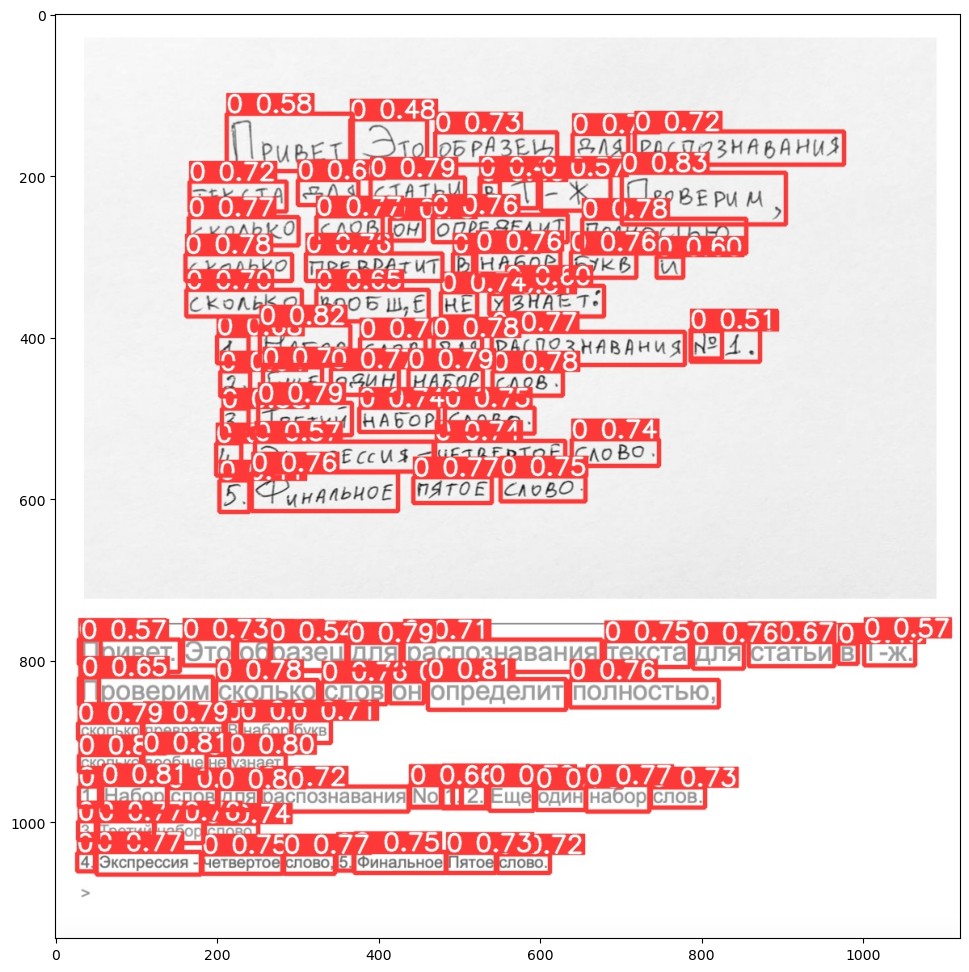

In [3]:
img = cv2.imread('/home/misha/runs/detect/predict/scanner-txt-30-v2.lzkn08qxjhkj.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img)

### как мы видим наша модель одинаково определяет как рукописный так и печатный текст
чтобы решить эту проблему я хочу добавить в модель не размеченные текста сгенерированные chatGPT  

In [130]:
import g4f
def ask_gpt():
    response = g4f.ChatCompletion.create(
        model=g4f.models.gpt_4,
        provider=g4f.Provider.ChatgptAi,
        messages=[{"role": "user", "content": "Привет, напиши, пожалуйста, текст похожий на какой-нибудь документ. В твоем сообщении не должно быть ничего кроме текста документа"}],
        stream=True,
    )
    return response

In [140]:
response = g4f.ChatCompletion.create(
        model=g4f.models.gpt_4,
        provider=g4f.Provider.FakeGpt,
        messages=[{"role": "user", "content": "Привет, напиши, пожалуйста, текст похожий на какой-нибудь документ. В твоем сообщении не должно быть ничего кроме текста документа. Внимание важно: используй символы _____ для обозначения полей, заполняемых человеком."}],
    )
print(response)

ДОКУМЕНТ

[Ваше Имя]
[Ваша Фамилия]
[Ваш Адрес]
[Город, Почтовый Индекс]

Дата: _____ [дата]

Уважаемый/Уважаемая [Фамилия],

Письмо-заявление

Я, нижеподписавшийся [Ваше Имя и Фамилия], проживающий по адресу [Ваш Адрес], обращаюсь с заявлением о _______________________________.

Просьба рассмотреть данное заявление и предоставить мне соответствующую информацию/разрешение/подтверждение в установленные законодательством сроки.

Благодарю за внимание к данному вопросу.

С уважением,
[Ваше Имя и Фамилия]
[Подпись]


In [141]:
parse_ans = response.split('\n')
parse_ans

['ДОКУМЕНТ',
 '',
 '[Ваше Имя]',
 '[Ваша Фамилия]',
 '[Ваш Адрес]',
 '[Город, Почтовый Индекс]',
 '',
 'Дата: _____ [дата]',
 '',
 'Уважаемый/Уважаемая [Фамилия],',
 '',
 'Письмо-заявление',
 '',
 'Я, нижеподписавшийся [Ваше Имя и Фамилия], проживающий по адресу [Ваш Адрес], обращаюсь с заявлением о _______________________________.',
 '',
 'Просьба рассмотреть данное заявление и предоставить мне соответствующую информацию/разрешение/подтверждение в установленные законодательством сроки.',
 '',
 'Благодарю за внимание к данному вопросу.',
 '',
 'С уважением,',
 '[Ваше Имя и Фамилия]',
 '[Подпись]']

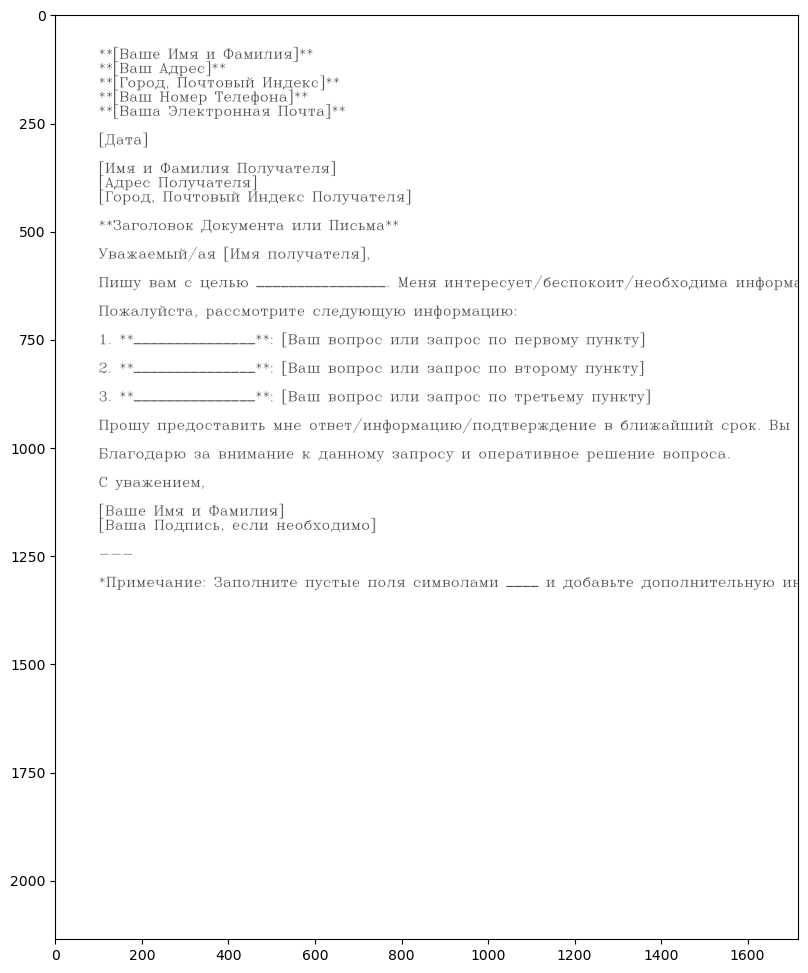

In [96]:
from random import randint
img = np.zeros([2000 + randint(0,500), 1500 + randint(0,350), 3],dtype=np.uint8)
img.fill(255)
indent = randint(30,45)
scale = randint(80,110)/100
thickness = randint(1,4)
for stringID, string in enumerate(parse_ans):
    #print(string)
    img = cv2.putText(img, string,(100,100+stringID*indent), 3, scale, (27,27,27), thickness)
plt.figure(figsize=(12, 12))
cv2.imwrite('/home/misha/GPTimages/imageGPT0.jpg', img)
plt.imshow(img)

In [97]:
from random import randint
for i in range(99,100):
    response = g4f.ChatCompletion.create(
            model=g4f.models.gpt_4,
            provider=g4f.Provider.FakeGpt,
            messages=[{"role": "user", "content": "Привет, напиши, пожалуйста, текст похожий на какой-нибудь документ. В твоем сообщении не должно быть ничего кроме текста документа"}],
        )
    print(response)
    parse_ans = response.split('\n')
    img = np.zeros([2000 + randint(0,500), 1500 + randint(0,350), 3],dtype=np.uint8)
    img.fill(255)
    indent = randint(30,45)
    scale = randint(80,110)/100
    thickness = randint(1,4)
    for stringID, string in enumerate(parse_ans):
        #print(string)
        img = cv2.putText(img, string,(100,100+stringID*indent), 3, scale, (27,27,27), thickness)
    cv2.imwrite(f'/home/misha/GPTimages/imageGPT{i}.jpg', img)


Договор № 123/456

г. Город, "дата"

Между Иванов Иван Иванович, именуемый в дальнейшем "Продавец", с одной стороны, и Петров Петр Петрович, именуемый в дальнейшем "Покупатель", с другой стороны, заключен настоящий договор о нижеследующем:

1. Предмет договора:

1.1 Продавец обязуется передать в собственность Покупателя, а Покупатель обязуется принять и оплатить товар в соответствии с условиями настоящего договора.

2. Цена и условия оплаты:

2.1 Общая стоимость товара составляет ____________ (______________) рублей.

2.2 Покупатель обязуется оплатить товар в течение 5 (пяти) рабочих дней с момента подписания настоящего договора.

3. Порядок и сроки поставки:

3.1 Поставка товара осуществляется Продавцом по адресу, указанному Покупателем, в течение ________ (________) дней с момента оплаты товара.

4. Гарантии:

4.1 Продавец гарантирует качество товара в соответствии с действующим законодательством.

5. Ответственность сторон:

5.1 В случае нарушения условий настоящего договора одной и

In [98]:
transform_GPT = A.Compose([
    A.Blur(blur_limit=10, p=0.7),
    A.RGBShift(p=0.3, r_shift_limit=0, g_shift_limit=10, b_shift_limit=20),
    A.PixelDropout(dropout_prob=0.15, p=0.25),
    A.ToGray(p=0.9),
    A.RandomBrightness(p=1, limit=0.1),
    A.Rotate(limit = 10, p=0.85),
    A.RandomCropFromBorders(p=0.2)
])

/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [99]:
path = '/home/misha/GPTimages/'
for id, img in enumerate(sorted(os.listdir(path))):
    image = cv2.imread(f'{path}{img}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if id % 10 == 1:
        cv2.imwrite(f'/home/misha/YOLOdataset/val/images/{img}', image)
        f = open(f'/home/misha/YOLOdataset/val/labels/{img}.txt', 'w+')
        path_to_YOLO = '/home/misha/YOLOdataset/val/images/'
    else:
        cv2.imwrite(f'/home/misha/YOLOdataset/train/images/{img}', image)
        f = open(f'/home/misha/YOLOdataset/val/labels/{img}.txt', 'w+')
        path_to_YOLO = '/home/misha/YOLOdataset/train/images/'
    for i in range(1,6):
        transformed = transform_GPT(image=image)
        cv2.imwrite(f'{path_to_YOLO}{img[:-4]}({i}).jpg', transformed['image'])
        f = open(f'{path_to_YOLO[:-7]}labels/{img[:-4]}({i}).txt', 'w+')

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f0cd25e2c90>


KeyboardInterrupt: 

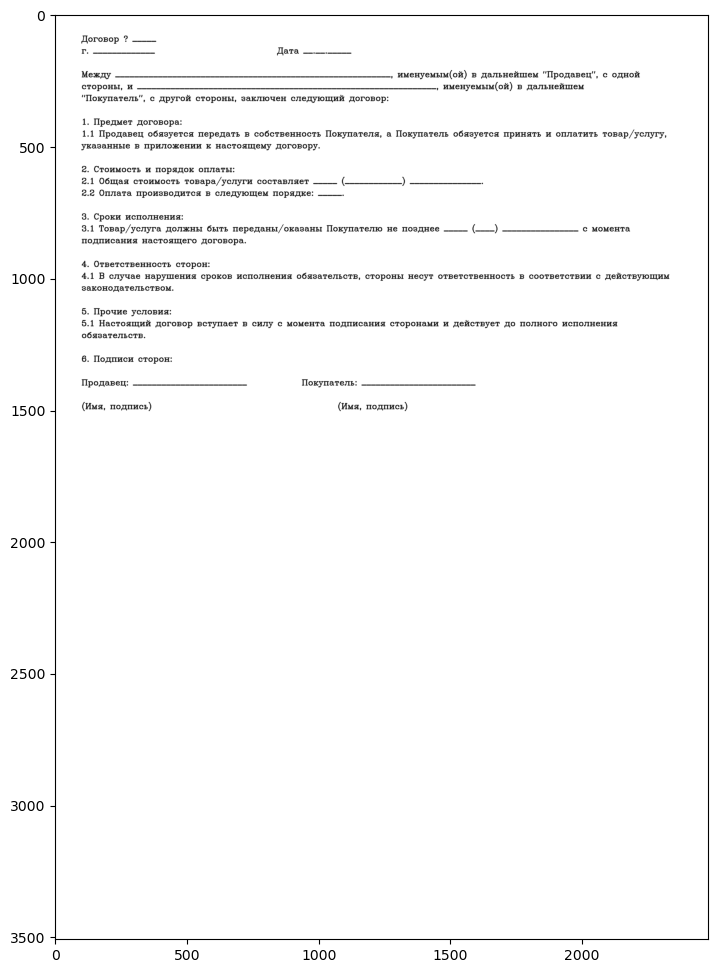

In [9]:
from random import randint
img = np.zeros([3508, 2480, 3],dtype=np.uint8)
img.fill(255)
indent = 0
for stringID, string in enumerate(parse_ans):
    while len(string) > 115:
        #print(string[:116].rfind(' '))
        index = string[:116].rfind(' ')
        tmp = string[:index]
        string = string[index+1:]
        img = cv2.putText(img, tmp,(100,100+(stringID+indent)*45), 3, 1, (27,27,27), 2)
        indent += 1
    img = cv2.putText(img, string,(100,100+(stringID+indent)*45), 3, 1, (27,27,27), 2)
# img = cv2.rectangle(img, (100,105+stringID*45), (352,105+stringID*45-40), (255,0,0), 2)
# img = cv2.rectangle(img, (100,105), (242,105-40), (255,0,0), 1)
# img = cv2.rectangle(img, (144,195), (322,150), (255,0,0), 1)
# img = cv2.rectangle(img, (482,195),(340,150), (255,0,0), 1)
# img = cv2.rectangle(img, (500,195),(620,150), (255,0,0), 1)
# img = cv2.rectangle(img, (100,195), (126,150), (255,0,0), 1)
plt.figure(figsize=(12, 12))
plt.imshow(img)

In [10]:
counter = 0
a = np.zeros([31,3],dtype=np.uint8)
a.fill(255)
for stringID in range(len(parse_ans)+indent):
    x_start = 100
    for x in range(100, img.shape[1]):
        if np.all(img[70+stringID*45:101+stringID*45,x] == np.array(a)):
            counter += 1
        else:
            counter = 0
        if counter == 16:
            img = cv2.rectangle(img, (x_start-2, 105+stringID*45), (x - counter+2,70+stringID*45), (255,0,0), 1)
            x_start = x
        if counter >= 20:
            x_start += 1

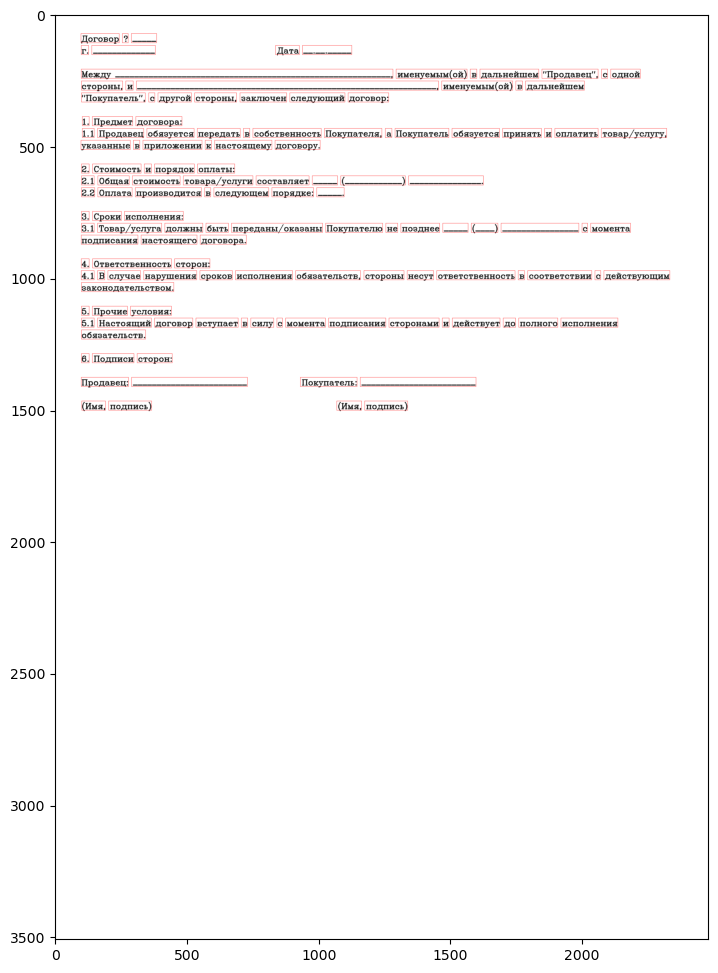

In [11]:
plt.figure(figsize=(12, 12))
plt.imshow(img)

In [99]:
file = open('/home/misha/Загрузки/augms/1_23.txt').read()
bboxes_str = file.split('\n')
bboxes = [x.split(' ')[1:] for x in bboxes_str]
bboxes = np.float32(bboxes[:-1])
class_labels = [x.split(' ')[0] for x in bboxes_str[:-1]]
img = cv2.imread('/home/misha/YOLOdataset/train/images/1_23.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transformed = transform_pipeline(image=img, bboxes=bboxes, class_labels=class_labels)
print(transformed['class_labels'])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76']


In [32]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
driver = webdriver.Firefox()
driver.get('https://handwritter.ru/')

In [33]:
driver.find_element(By.ID, 'text').send_keys("абоба" )
driver.find_element(By.ID, 'butt').click()
driver.find_element(By.ID, 'text').clear()
driver.find_element(By.ID, 'but_screenshot').click()

In [138]:
import random as r
import time
def ask_gpt1(context):
    response = g4f.ChatCompletion.create(
        model=g4f.models.gpt_4,
        provider=g4f.Provider.FakeGpt,
        messages=[{"role": "user", "content": f"Сгенерируй один вариант предложения или слова, \
            которое могло бы использоваться в каком-либо документе и подходило бы к данному контексту: {context}. \
            В твоем сообщении не должно быть ничего лишнего, только ответ."}],
    )
    time.sleep(11)
    return response
def ask_gpt2(ln):
    a = r.randint(0, 100)
    if a < 70:
        response = g4f.ChatCompletion.create(
            model="gpt-3.5-turbo",
            provider=g4f.Provider.FakeGpt,
            messages=[{"role": "user", "content": f"Сгенерируй один вариант предложения или слова, \
            которое могло бы использоваться в каком-либо документе длиной примерно в {ln//1.5} символов. Например, это может быть \
            название компании, фамилия, и имя человека или просто какое-то предложение. В твоем сообщении не должно быть ничего \
            лишнего, только ответ."}],
        )
    elif a < 90:
        response = g4f.ChatCompletion.create(
            model="gpt-3.5-turbo",
            provider=g4f.Provider.FakeGpt,
            messages=[{"role": "user", "content": f"Сгенерируй один вариант предложения или слова, \
            которое могло бы использоваться в каком-либо документе длиной примерно в {ln//1.5} символов. \
            В твоем сообщении не должно быть ничего лишнего, только ответ."}],
        )
    else:
        return get_name()
    time.sleep(11)
    return response
def get_name():
    if r.randint(1, 100) < 75:
        surname = open('top_surnames.txt').read().split('\n')[r.randint(0, 99)]
    else:
        surname = open('surnames.txt').read().split('\n')[r.randint(0, 14650)]
    if r.randint(0,1) == 0:  
        surname += 'а'
        if r.randint(1, 100) < 75:
            name = open('top_female_names.txt').read().split('\n')[r.randint(0, 19)]
        else:
            name = open('female_names.txt').read().split('\n')[r.randint(0, 937)]
        lastname = open('female_lastnames.txt').read().split('\n')[r.randint(0, 56)]
    else:
        if r.randint(1, 100) < 75:
            name = open('top_male_names.txt').read().split('\n')[r.randint(0, 19)]
        else:
            name = open('male_names.txt').read().split('\n')[r.randint(0, 734)]
        lastname = open('male_lastnames.txt').read().split('\n')[r.randint(0, 64)]
    if r.randint(1, 100) < 70:
        if r.randint(1, 100) < 80:
            return surname + ' ' + name[0] + '.' + lastname[0] + '.'
        else:
            return surname + ' ' + name[0] + '. ' + lastname[0] + '.'
    else:
        return surname + ' ' + name + ' ' + lastname
def get_FIO():
    if r.randint(1, 100) < 75:
        surname = open('top_surnames.txt').read().split('\n')[r.randint(0, 99)]
    else:
        surname = open('surnames.txt').read().split('\n')[r.randint(0, 14650)]
    if r.randint(0,1) == 0:  
        surname += 'а'
        if r.randint(1, 100) < 75:
            name = open('top_female_names.txt').read().split('\n')[r.randint(0, 19)]
        else:
            name = open('female_names.txt').read().split('\n')[r.randint(0, 937)]
        lastname = open('female_lastnames.txt').read().split('\n')[r.randint(0, 56)]
    else:
        if r.randint(1, 100) < 75:
            name = open('top_male_names.txt').read().split('\n')[r.randint(0, 19)]
        else:
            name = open('male_names.txt').read().split('\n')[r.randint(0, 734)]
        lastname = open('male_lastnames.txt').read().split('\n')[r.randint(0, 64)]
    return surname + ' ' + name + ' ' + lastname
def get_number_of_doc():
    a = r.randint(1,1999)
    return str(a)
def get_mail():
    response = g4f.ChatCompletion.create(
            model="gpt-3.5-turbo",
            provider=g4f.Provider.FakeGpt,
            messages=[{"role": "user", "content": "Придумай электронную почту. В твоем сообщениие не должно быть ничего лишнего, только почта"}],
        )
    time.sleep(11)
    return response
def get_INN():
    INN = ''
    for i in range(12):
        INN += str(r.randint(0,9))
    return INN
def get_town():
    if r.randint(1,2) == 1:
        if r.randint(1,3) == 1:
            town = 'Санкт-Петербург'
        else:
            town = 'Москва'
    else:
        town = open('towns.txt').read().split('\n')[r.randint(0, 49)]
    return town
def get_cost():
    return str(r.randint(1, 1000) * 1000)
def get_sign():
    return 0
def get_year():
    year = r.randint(1,20) + 2015
    return str(year)
def get_date():
    date = ''
    day = str(r.randint(1, 31))
    month = str(r.randint(1, 12))
    year = str(r.randint(1,20) + 2015)
    if r.randint(1,2) == 2:
        year = year[2:]
    if r.randint(1,2) == 2:
        if int(month) < 10:
            month = '0' + str(month)
        if int(day) < 10:
            day = '0' + day
        return day + '.' + month + '.' + year
    else:
        return day + '.' + month + '.' + year
def get_phone_number():
    number ='+7'
    a = r.randint(1,3)
    if a == 1:
        for i in range(10):
            if i in [0,3,6,8]:
                number += ' '
            number += str(r.randint(0,9))
    elif a == 2:
        for i in range(10):
            if i in [0,3,6,8]:
                if i == 3:
                    number += ')'
                number += ' '
                if i == 0:
                    number += '('
            number += str(r.randint(0,9))
    else:
        for i in range(10):
            number += str(r.randint(0,9))
def get_adress():
    town = get_town()
    street = open('streets.txt').read().split('\n')[r.randint(0, 99)]
    if r.randint(1,100) < 80:
        house_number = str(r.randint(1,99))
    else:
        house_number = str(r.randint(100, 300))
    if r.randint(1,100) > 94:
        building_number = f', к. {str(r.randint(1,9))}'
    else:
        building_number = ''
    adress = f'г. {town}, ул. {street}, д. {house_number}{building_number}'
    return adress
def get_passport():
    return 'пасспорт'
def get_passport_serial():
    serial = ''
    for i in range(4):
        serial += str(r.randint(0,9))
    return serial
def get_passport_number():
    number = ''
    for i in range(6):
        number += str(r.randint(0,9))
    return number
def get_label():
    response = g4f.ChatCompletion.create(
            model="gpt-3.5-turbo",
            provider=g4f.Provider.FakeGpt,
            messages=[{"role": "user", "content": "Придумай название фирмы. В твоем сообщениие не должно быть ничего лишнего, только название"}],
        )
    time.sleep(11)
    return response
def get_two_digits():
    a = r.randint(0,35)
    if a < 10:
        s = '0' + str(a)
    else:
        s = str(a)
    return s
def switcher(cat):
    match cat:
        case 'name': return get_name()
        case 'FIO': return get_FIO()
        case 'number_of_doc': return get_number_of_doc()
        case 'mail': return get_mail()
        case 'phone_number': return get_phone_number()
        case 'town': return get_town()
        case 'adress': return get_adress()
        case 'INN': return get_INN()
        case 'date': return get_date()
        case 'cost': return get_cost()
        case 'sign': return get_sign()
        case 'year': return get_year()
        case 'passport': return get_passport()
        case 'passport_serial': return get_passport_serial()
        case 'passport_number': return get_passport_number()
        case 'label': return get_label()
        case 'two_last_digits_of_year': return get_two_digits()
        case 0: return ask_gpt1()
        case 1: return ask_gpt2()
fit = {
    'name': ("кому", "от", "клиент", "между", "имя", "фамилия", "уважаемые", "арендодатель", "арендатор", "заказчик", "исполнитель", "консультант", "юрист", "[ваше имя и фамилия]", "ваше имя и фамилия", "заявитель", "гражданин", "гражданинка", "с уважением", "продавец", "покупатель"),
    'FIO': ("фио", ""),
    'number_of_doc': ('#', '№'),
    'phone_number': ("телефон", "контакт", "телефона"),
    'mail': ("электронная почта", "почта", 'email', 'e-mail'),
    'town': ("г.", "г", "город"),
    'adress': ("адрес", "место", "проживания"),
    'INN': ("инн/огрн", "инн", "огрн"),
    'date': ("дата", "срок", "до", "срок выполнения", "срок исполнения", "[дата]"),
    'cost': ("цена", "плата", "платы", "рублей", "руб", "руб.", "стоимость"),
    'sign': ("подпись", "роспись"),
    'year': ('год', "года"),
    'passport': ("паспорт", 'удостоверение', "личность"),
    'passport_serial': ("серия", ''),
    'passport_number': ("номер", ''),
    'label': ("общество", "ООО", "название", "сторона")
}

In [134]:
text = []
for stringID, string in enumerate(parse_ans):
    while len(string) > 115:
        index = string[:116].rfind(' ')
        tmp = string[:index]
        count = 0
        words = tmp.split()
        for id, word in enumerate(words):
            if '_' in word:
                count += 1
            else:
                if count == 2:
                    tmp = tmp.replace(' ' + words[id-1], '')
                count = 0
            if count == 2 and id == len(words) - 1:
                tmp = tmp.replace(' ' + word, '.')
            if count == 3:
                tmp = tmp.replace(words[id-2] + ' ' + words[id-2] + ' ' + words[id-2], 'Дата: __________')
        text.append(tmp)
        string = string[index+1:]
    words = string.split()
    count = 0
    for id, word in enumerate(words):
        if '_' in word:
            count += 1
        else:
            if count == 2:
                string = string.replace(' ' + words[id-1], '')
            count = 0
        if count == 2 and id == len(words) - 1:
                string = string.replace(' ' + word, '.')
        if count == 3:
            string = string.replace(words[id-2] + ' ' + words[id-1] + ' ' + words[id], 'Дата: __________')
    text.append(string)

In [135]:
def get_category(words):
    words = words.lower()
    for let in '[]()"\',.?!*^:;`~*%':
        words = words.replace(let, '')
    if 'подпись' in words or 'роспись' in words:
        return 'sign'
    for cat in fit:
        if words in fit[cat]:
            return cat
    for id, word in enumerate(words.split()):
        if word == 'адрес':
            if 'почта' in words or 'почты' in words or 'почт' in words or 'почту' in words:
                return 'mail'
            else:
                return 'adress'
        for cat in fit:
            if word in fit[cat]:
                if word == 'с':
                    if id == 0 or id == len(word.split()) - 1:
                        return cat
                    else:
                        return 0
                return cat
    for word in words.split('/'):
        for cat in fit:
            if word in fit[cat]:
                return cat
    return 0

In [139]:
flag = False
nutshell_words = ''
generated_text = ''
category = ''
for stringID, string in enumerate(text):
    words = string.split()
    i = 0
    while i < len(words) - 1:
        #print(words, i)
        if '_' in words[i] and '[' in words[i+1] or '_' in words[i+1] and ']' in words[i]:
            words.pop(i)
        i += 1
    for id, word in enumerate(words):
        if '[' in word and ']' in word:
            nutshell_words += word[word.find('[') + 1 : word.find(']')]
            category = get_category(nutshell_words)
            #print(category, nutshell_words)
            nutshell_words = ''
        elif '[' in word:
            flag = True
            nutshell_words += word[word.find('[') + 1:]
        elif ']' in word:
            flag = False
            nutshell_words += ' '
            nutshell_words += word[:word.find(']')]
            category = get_category(nutshell_words)
            if category == 0:
                generated_text = ask_gpt1(nutshell_words)
                #print(generated_text)
            else:
                generated_text = switcher(category)
            #print(category, nutshell_words)
            nutshell_words = ''
        elif flag == True and (not('[' in word)):
            nutshell_words += ' '
            nutshell_words += word
        elif '_' in word:
            flag_ready = False
            if '20' in word:
                generated_text = switcher('two_last_digits_of_year')
                print(generated_text)
                continue
            nutshell_words = ''
            #print(word)
            if id > 0:
                tmp = words[:id]
                tmp = tmp[::-1]
                if len(tmp) < 5:
                    buff = words[id+1:]
                    if len(buff) > 5:
                        buff = buff[:5]
                    tmp += buff
                #print(tmp)
            else:
                tmp = words[id+1:]
                if len(tmp) < 5:
                    buff = words[:id]
                    buff = buff[::-1]
                    if len(buff) > 5:
                        buff = buff[:5]
                    tmp += buff
            if len(tmp) == 0:
                flag_ready = True
                if stringID != 0:
                    nutshell_words = text[stringID-1]
                elif stringID != len(text) - 1:
                    nutshell_words = text[stringID+1]
            if flag_ready == False:
                for idx, el in enumerate(tmp):
                    nutshell_words += el
                    if id != len(tmp)-1:
                        nutshell_words += ' '
            category = get_category(nutshell_words)
            if category == 'name' and len(text) - 1 != stringID:
                t = text[stringID + 1]
                new_cat = get_category(t)
                if new_cat == 'sign':
                    category = 'sign'
            if category == 0:
                generated_text = ask_gpt2(len(word))
                #print(generated_text)
            else:
                #print(category, nutshell_words)
                generated_text = switcher(category)    
        print(category, generated_text, nutshell_words)

  
  
  
number_of_doc 987 № аренды Договор 
number_of_doc 987 № аренды Договор 
town Москва г. 
town Москва г. 
town Москва г. 
town Москва г. 
town Москва г. 
town Москва г. 
name Козлова А.А. Арендодатель: 1.1. 
name Козлова А.А. Арендодатель: 1.1. 
name Козлова А.А. Арендодатель: 1.1. 
name Козлова А.А. Арендодатель: 1.1. 
name Козлова А.А. Арендодатель: 1.1. 
name Козлова А.А. Арендодатель: 1.1. 
name Козлова А.А. Арендодатель: 1.1. 
name Самойличенко Филат Иваныч Арендатор: 1.2. 
name Самойличенко Филат Иваныч Арендатор: 1.2. 
name Самойличенко Филат Иваныч Арендатор: 1.2. 
name Самойличенко Филат Иваныч Арендатор: 1.2. 
name Самойличенко Филат Иваныч Арендатор: 1.2. 
name Самойличенко Филат Иваныч Арендатор: 1.2. 
name Самойличенко Филат Иваныч Арендатор: 1.2. 
name Самойличенко Филат Иваныч Арендатор: 1.2. 
name Самойличенко Филат Иваныч Арендатор: 1.2. 
name Самойличенко Филат Иваныч Арендатор: 1.2. 
name Самойличенко Филат Иваныч Арендатор: 1.2. 
name Самойличенко Филат Иваны

In [137]:
text

['Договор аренды № _____',
 'г. ________________',
 '',
 '1. СТОРОНЫ ДОГОВОРА:',
 '',
 '1.1. Арендодатель: ________________________________________________',
 '(ФИО, адрес, контактные данные)',
 '',
 '1.2. Арендатор: ___________________________________________________',
 '(ФИО, адрес, контактные данные)',
 '',
 '2. ПРЕДМЕТ ДОГОВОРА:',
 '',
 '2.1. Арендодатель передает в аренду, а Арендатор принимает в аренду объект недвижимости по адресу:',
 '_____________________________',
 '(Описание объекта, адрес)',
 '',
 '3. СРОК АРЕНДЫ:',
 '',
 '3.1. Договор заключен на срок с _____ по _____.',
 '(Указать начальную и конечную даты)',
 '',
 '4. РАЗМЕР АРЕНДНОЙ ПЛАТЫ:',
 '',
 '4.1. Размер арендной платы составляет _______ (в валюте) ежемесячно.',
 '(Указать сумму и валюту)',
 '',
 '5. ПОРЯДОК ОПЛАТЫ:',
 '',
 '5.1. Арендатор обязуется вносить арендную плату ежемесячно до ____ числа каждого месяца.',
 '(Указать срок оплаты)',
 '',
 '6. ОБЯЗАННОСТИ СТОРОН:',
 '',
 '6.1. Арендодатель обязуется обеспечи

In [197]:
response = g4f.ChatCompletion.create(
            model="gpt-3.5-turbo",
            provider=g4f.Provider.FakeGpt,
            messages=[{"role": "user", "content": "Придумай название фирмы. В твоем сообщениие не должно быть ничего лишнего, только название"}],
        )
response

'Эко-Лайт Технолоджи'

['jjhj', 'hgjh']

In [44]:
data = open('streets.txt').read().split('\n')
new_data = ''
for i in range(len(data)):
    if i % 3 == 0:
        s = data[i][4:data[i].find(',')] + '\n'
        new_data += s.replace('\t', '')
f = open('new_streets.txt', 'w+').write(new_data)